# Exploring the WIFI ArenA data

##### B.L. de Vries, Sept 2018

In [1]:
import json 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from matplotlib.patches import Ellipse

The size of the arena in meters is approximately

In [2]:
#arena foodball field size is 105m by 68m
arena_x_min, arena_x_max = -80, 80
arena_y_min, arena_y_max = -60, 60

The location of several files we need. Please edit them to point to the data on your disk

First three files are a set of location and mac address data for three days. The event was during the end of the first and during the second day.
The drone_file shows the location of several accesspoints in the arena. The data only comes from the two arms of drones in the field. Not the accesspoints in the outer parts of the stadium.

In [3]:
# DATA DIRECTORIES
data_dir = os.path.join("..","data","ArenaData","arena_fits")
drone_dir = os.path.join("..","data","ArenaData")
# DATA FILES
list_date_data_file = ["2015-07-04", "2015-07-05", "2015-07-06", "2015-07-07"]
drone_file = "drones_arena_sensation.csv"
drone_locations = pd.read_csv(os.path.join(drone_dir, drone_file))

# DIR TO SAVE RESULTS INTO
dir_results = "exploring_data_output"

First we read in the json files with location data and convert them to Pandas dataframes

In [4]:
rerun = False # Set this true if you want to overwrite your saved results!

list_data_frames = []
for date_data_file in list_date_data_file:
    print("Processing: {}".format(date_data_file))
    data_file_json = os.path.join(data_dir, date_data_file+".json")
    data_file_csv = os.path.join(dir_results, date_data_file+".csv")

    if os.path.isfile(data_file_csv) and not rerun:
        print("    Found on disk")
        df = pd.read_csv(data_file_csv)
    else:
        print("    Calculating")
        with open(data_file_json) as f:
            file_content = f.readlines()

        data = {"mac": [],
                "timestamp": [],
                "x_err": [],
                "y_err": [],
                "fitted": [],
                "x_sample_error": [],
                "y_sample_error": [],
                "probChi2": [],
                "Chi2PerDof": [],
                "x": [],
                "y": [],
                "local_mac": []
               }

        for line in file_content:
            jsline = json.loads(line)
            #json_lines.append(jsline)#now json_lines contains all lines of data
            data["mac"].append(jsline["value"]["sourceMac"])
            data["local_mac"].append(jsline["value"]["trackeeHistory"]["localMac"])
            data["timestamp"].append(jsline["measurementTimestamp"]/1000) # sec
            data["x_err"].append(jsline['value']['averagecoordinate']['error']['coordinates'][0]/math.sqrt(jsline['value']['trackeeHistory']['nMeasurements']))
            data["y_err"].append(jsline['value']['averagecoordinate']['error']['coordinates'][1]/math.sqrt(jsline['value']['trackeeHistory']['nMeasurements']))
            data["fitted"].append(jsline['value']['trackeeHistory']['fitStatus'])
            data["x_sample_error"].append(jsline['value']['averagecoordinate']['error']['coordinates'][0])
            data["y_sample_error"].append(jsline['value']['averagecoordinate']['error']['coordinates'][1])
            data["probChi2"].append(jsline['value']['trackeeHistory']['probChi2'] )
            data["Chi2PerDof"].append(jsline['value']['trackeeHistory']['chi2PerDof'] )
            data["x"].append(jsline["value"]["averagecoordinate"]["avg"]["coordinates"][0])
            data["y"].append(jsline["value"]["averagecoordinate"]["avg"]["coordinates"][1])
        df = pd.DataFrame(data)
        df.to_csv(data_file_csv)
    list_data_frames.append(df)


Processing: 2015-07-04
    Found on disk
Processing: 2015-07-05
    Found on disk
Processing: 2015-07-06
    Found on disk
Processing: 2015-07-07
    Found on disk


Here we declare a function that slices the dataframe as we want. For example selecting only locations inside the stadium, with good errors or with a certain mac address

In [5]:
def slice_data_frame(df, apply_filter_using_errors = False, slice_on_mac = None):
    
    full_slice = [True for i in df["mac"]]
    
    if apply_filter_using_errors:
        slice_best =    (df["probChi2"] > 0.3) & \
                        (df["x_err"] < 5) & \
                        (df["Chi2PerDof"] <1.2) 
        full_slice = full_slice & slice_best
        
    if slice_on_mac:
        full_slice = full_slice & (df["mac"]==slice_on_mac)

    slice_non_local = (df["local_mac"] == 0)
    full_slice = full_slice & slice_non_local

    slice_coord_inside = \
        (df["x"] > arena_x_min) &\
        (df["x"] < arena_x_max) &\
        (df["y"] > arena_y_min) &\
        (df["y"] < arena_y_max)

    full_slice = full_slice & slice_coord_inside
    
   
    return df[full_slice]

We make two lists of mac addresses to study further. For this we first make ```uni_macs_per_day```, which is a list of sets (one set per day) containing the unique mac addresses detected that day. Then we generate:
- ```macs_present_during_all_days```: these could be stationairy emitters
- ```macs_not_present_last_day```: likely party people

In [6]:
uni_macs_per_day = []

last_day = 3
day = 0
for df in list_data_frames:
    day = day + 1
    df = slice_data_frame(df, apply_filter_using_errors=False)
    uni_macs_per_day.append(set(df["mac"]))
    print("Unique mac addresses for day {}: {}".format( day, len(set(df["mac"])) ))

macs_present_during_all_days = []
for mac in uni_macs_per_day[last_day]: # We walk over the last, since that one contains the least macs
    if mac in uni_macs_per_day[0] and mac in uni_macs_per_day[1] and mac in uni_macs_per_day[2]:
        macs_present_during_all_days.append(mac)
        
print("macs_present_during_all_days: {}".format( len(macs_present_during_all_days)))

macs_not_present_last_day = []
for mac in uni_macs_per_day[1]:
    if not mac in uni_macs_per_day[last_day]:
        macs_not_present_last_day.append(mac)
print("macs_not_present_last_day: {}".format( len(macs_not_present_last_day)))

Unique mac addresses for day 1: 6559
Unique mac addresses for day 2: 11205
Unique mac addresses for day 3: 431
Unique mac addresses for day 4: 423
macs_present_during_all_days: 9
macs_not_present_last_day: 11167


Now for both mac groups ```macs_present_during_all_days``` and ```macs_not_present_last_day``` and I generate information like the total number of detections (key is ```"nr_det"```).

In [7]:
mac_lists = {"macs_present_during_all_days": macs_present_during_all_days, 
             "macs_not_present_last_day": macs_not_present_last_day}

# I will store the results in this dict and at the end convert it to a dataframe
mac_summary_lists = \
            {"macs_present_during_all_days": [], 
             "macs_not_present_last_day": []}

rerun = False # Set this true if you want to overwrite your saved results!

for name in mac_lists:
    print("***** "+name)
    mac_list = mac_lists[name]
    file_mac_info_summary = os.path.join(dir_results, name+"_summary.csv")

    if os.path.isfile(file_mac_info_summary) and not rerun:
        print("   Found on disk")
        mac_summary_lists[name] = pd.read_csv(file_mac_info_summary)
        
    else:
        info_per_device = []
        counter = 0
        counter2 = 0

        Tdf = pd.concat(list_data_frames)# Take the info from all days together
        Tdf = slice_data_frame(Tdf, apply_filter_using_errors= True)
        for mac in mac_list:
            idf = Tdf[Tdf["mac"] == mac]

            length = len(idf)
            if length != 0:
                t_min = min(idf['timestamp'])
                t_max = max(idf['timestamp'])
            else:
                t_min=None
                t_max = None
            info_per_device.append( 
                {"mac": mac, "nr_det": length, "t_min": t_min, "t_max": t_max}
            )

            counter+=1
            counter2 +=1
            if counter2 == 200:
                print(counter, "of", len(mac_list))
                counter2=0

        mac_summary = pd.DataFrame(info_per_device)
        mac_summary=mac_summary.sort_values("nr_det", ascending=False)
        
        mac_summary_lists[name] = mac_summary
        
        mac_summary.to_csv(file_mac_info_summary)

***** macs_present_during_all_days
   Found on disk
***** macs_not_present_last_day
   Found on disk


Now we have a look at the number of detections for ```macs_present_during_all_days```

In [8]:
mac_summary_lists["macs_present_during_all_days"]

,Unnamed: 0,mac,nr_det,t_max,t_min
0,7,2d1ff804-c499-4163-b90f-003df1e4ec65,37164,1.436274e+09,1.436033e+09
1,6,aee6d072-1925-4832-a1c6-9b3602b1e741,5152,1.436265e+09,1.436033e+09
2,5,1c1295f7-4123-4c39-bc48-a3433859c79c,1954,1.436274e+09,1.436071e+09
3,3,f174f340-878a-4d6e-aa9b-50a129780844,353,1.436273e+09,1.436033e+09
4,1,7e44b914-585d-4bbb-96d5-7c7cfc662250,340,1.436272e+09,1.436036e+09
5,8,b8816f2a-8127-4f6f-b2ac-a974e7478cd1,111,1.436260e+09,1.436036e+09
6,4,486973f4-756f-4fac-875b-71ea41ca0984,61,1.436270e+09,1.436079e+09
7,0,eccd478d-c402-4d72-9cba-bed668b15782,18,1.436273e+09,1.436034e+09
8,2,a6e8f1e3-8260-4797-b394-1da6a5f88011,0,NaN,NaN


And we have a look at a few macs from devices only present on the party day (```macs_not_present_last_day```)

In [9]:
mac_summary_lists["macs_not_present_last_day"].head(5)

,Unnamed: 0,mac,nr_det,t_max,t_min
0,319,2c019c2d-7e9e-42b1-b3bd-1797c918d4a7,6523,1.436067e+09,1.436047e+09
1,10707,e1deda99-163f-4b68-9ade-e1f05d070bf2,3463,1.436070e+09,1.436027e+09
2,3908,6cab229a-e15d-48b7-ab1e-5ddca3d7e283,3214,1.436070e+09,1.436027e+09
3,8090,280e9a33-fe52-4129-ade5-23aa12cee33c,2952,1.436197e+09,1.436076e+09
4,7491,8ff7bb98-b590-4233-9a0a-1b52d9ac2a0d,2656,1.436116e+09,1.436073e+09


In [10]:
mac_summary_lists["macs_not_present_last_day"].iloc[50:52]

,Unnamed: 0,mac,nr_det,t_max,t_min
50,8373,560cef8b-8080-4412-a038-f8bd4c7f534b,401,1.436066e+09,1.436050e+09
51,2494,f7461758-c3c0-4c55-8ff6-57a5fd3fa3e7,401,1.436199e+09,1.436084e+09


Now we plot a map of the detections, time series for the x and y coordinates and distributions for the x and y coordinates on the day of the party.

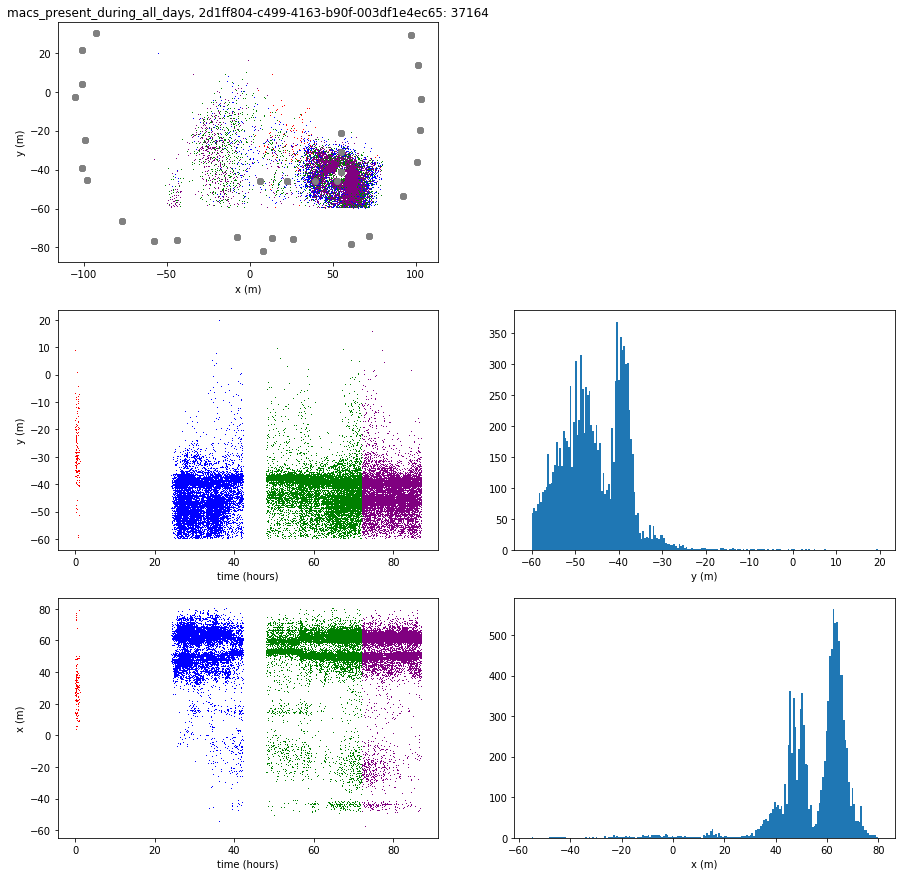

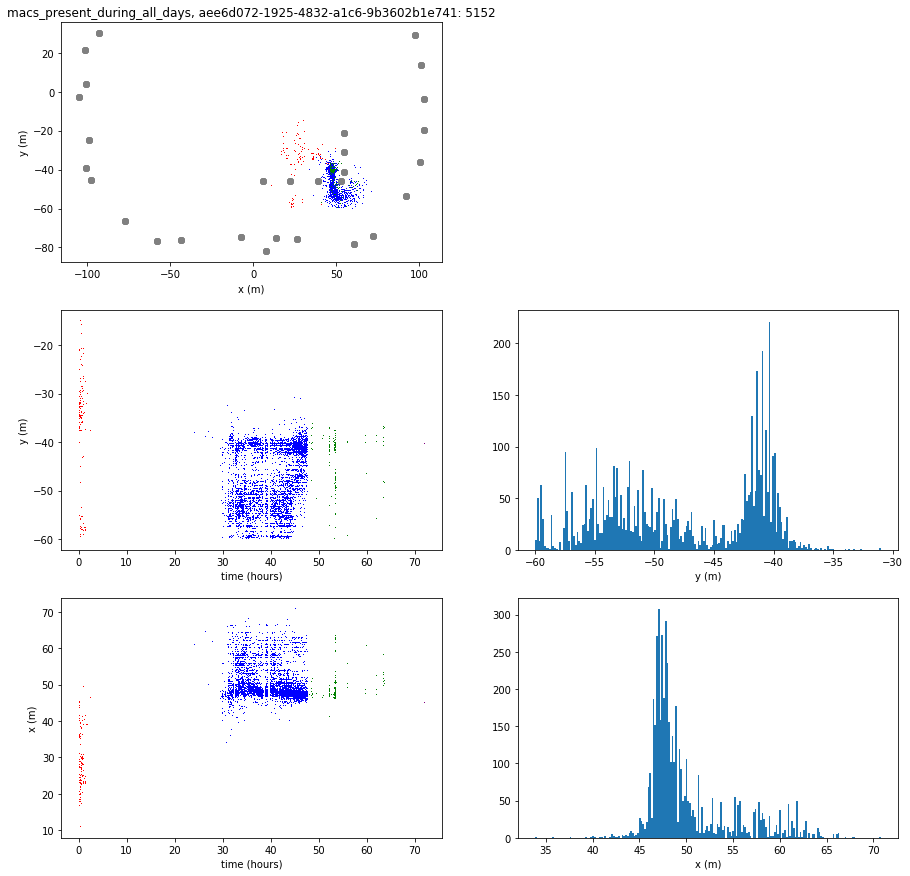

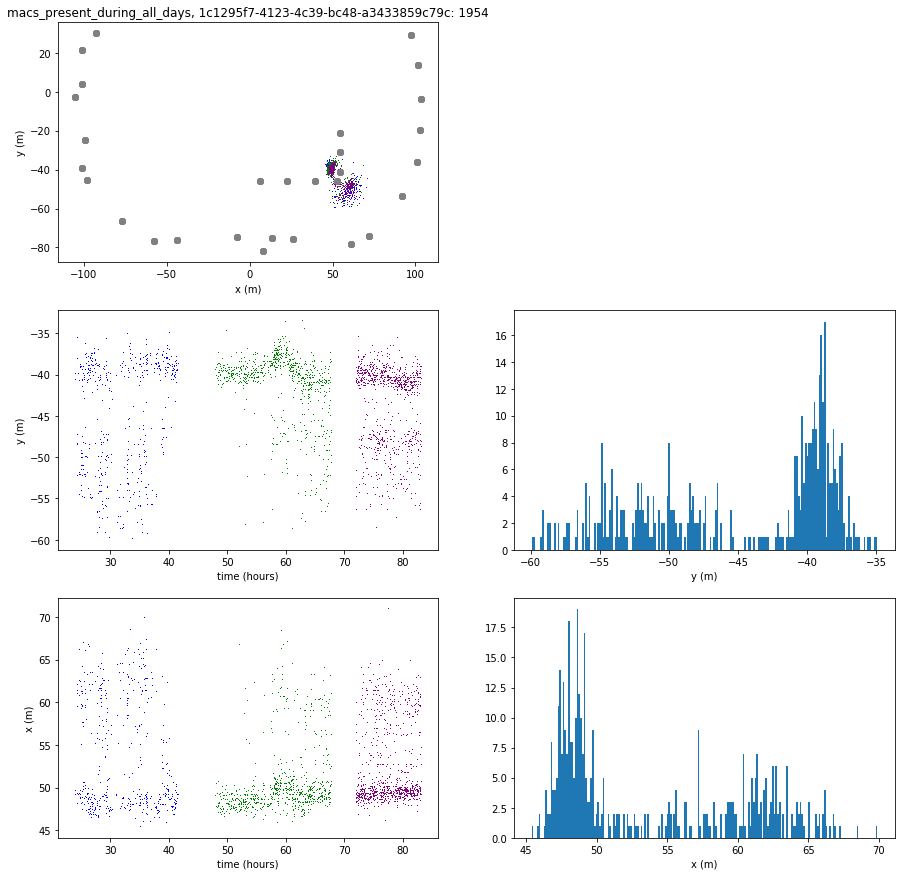

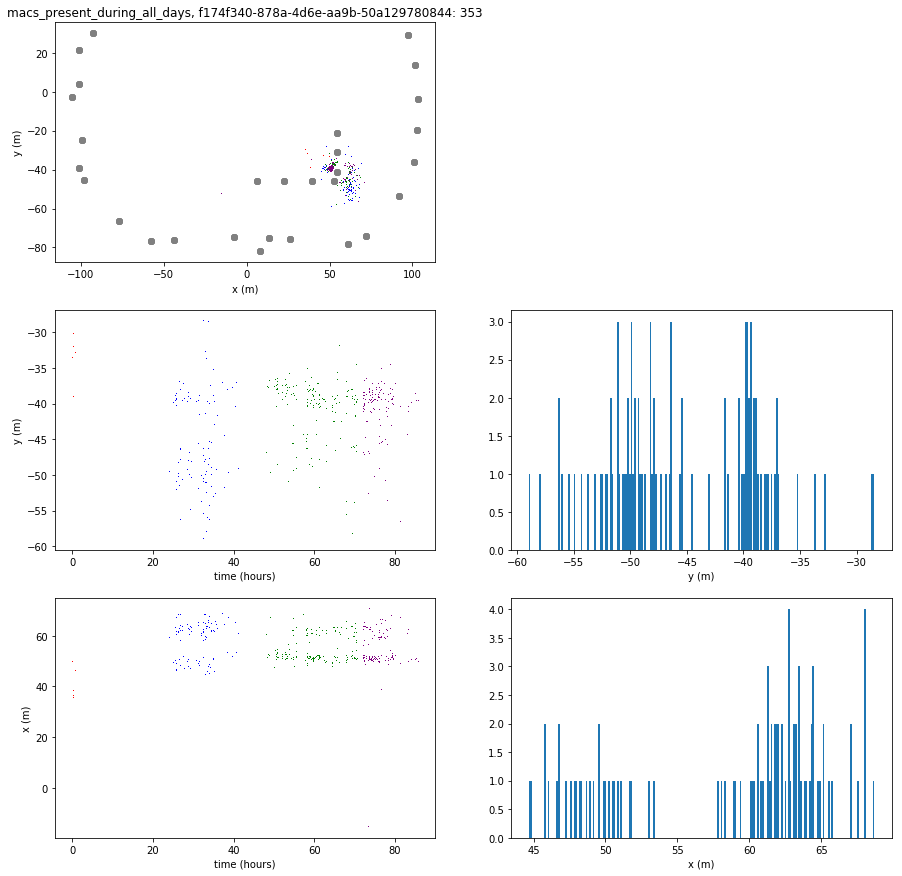

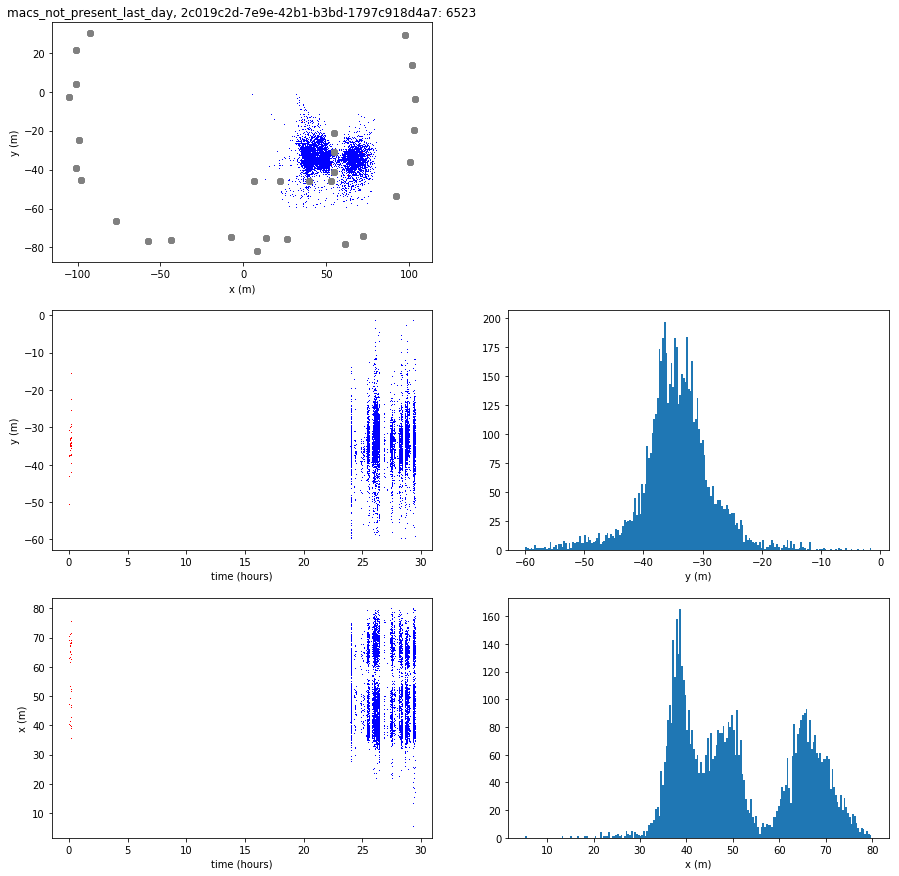

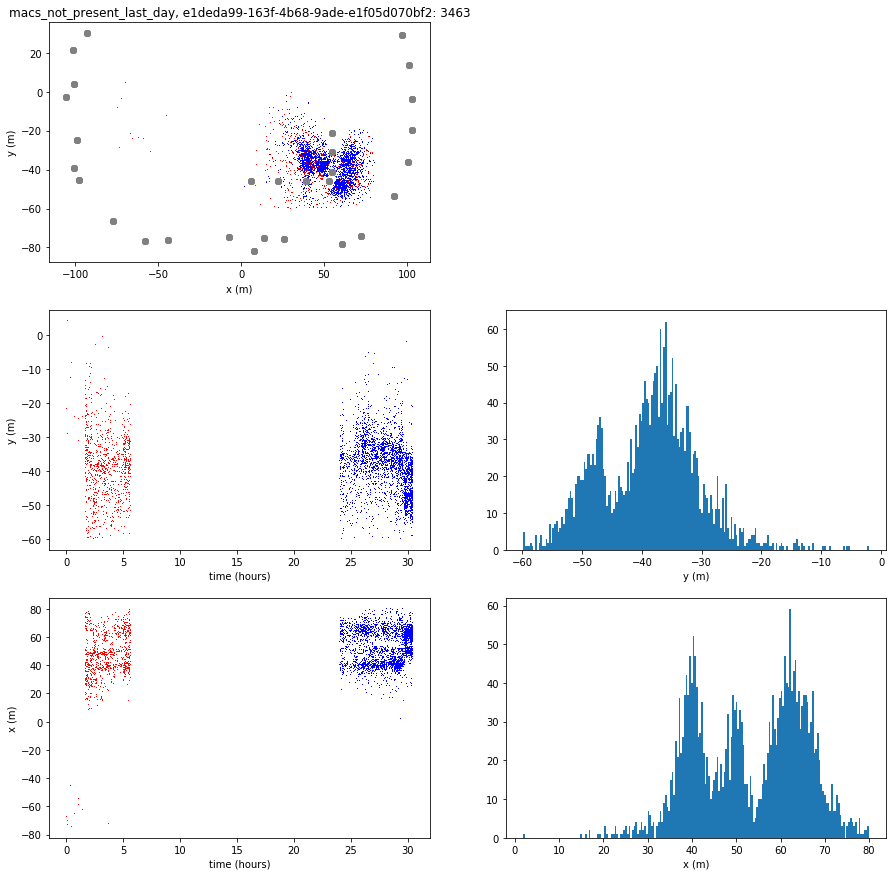

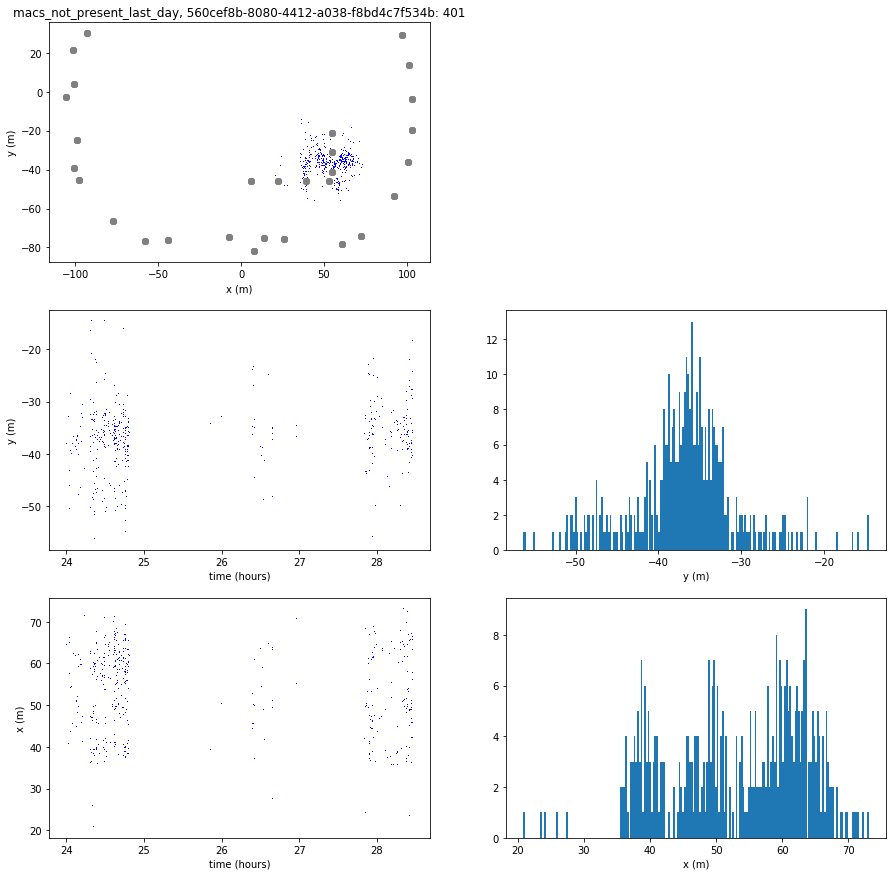

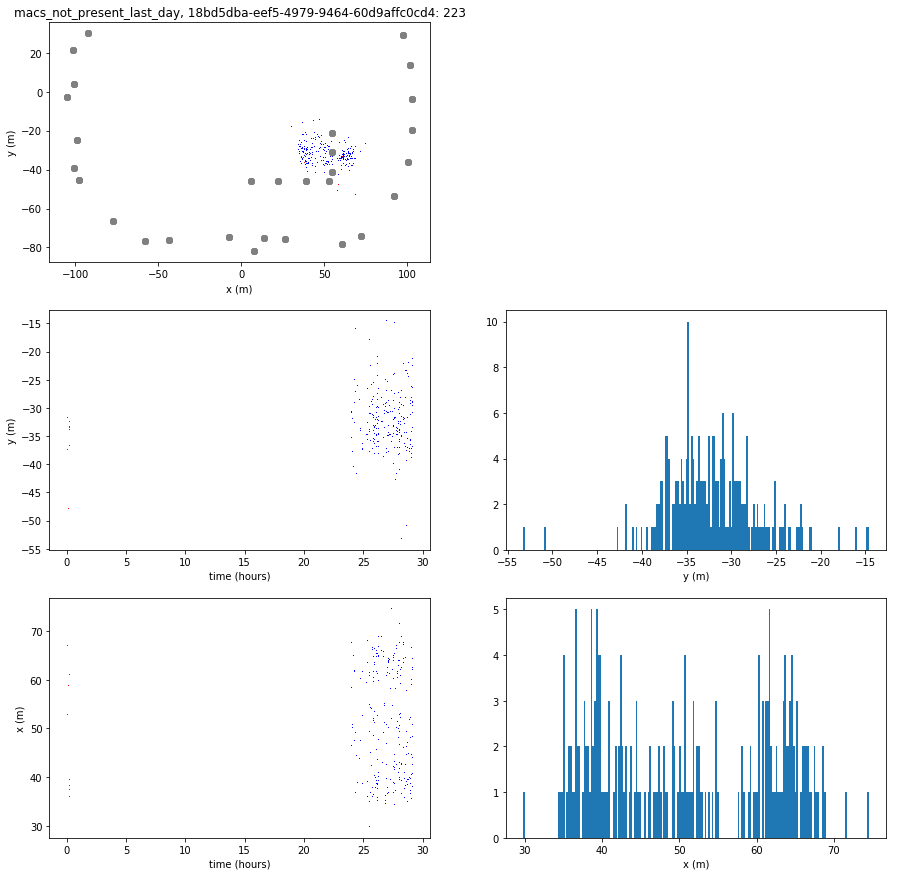

In [ ]:

for name in mac_summary_lists:
    mac_summary = mac_summary_lists[name]
    if "last_day" in name:
        indexes_to_plot = [0,1,50,100,200]
    else:
        indexes_to_plot = [0, 1, 2, 3]
        
    for i in indexes_to_plot:
        ex_mac = mac_summary.iloc[i]["mac"]
        nr_det = mac_summary.iloc[i]["nr_det"]
        colors = ["red", "blue", "green", "purple"]
        
        fig = plt.figure(0, figsize=(15,15))    
        ax1 = fig.add_subplot(321, label="ax1")
        ax2 = fig.add_subplot(323, label="ax2")
        ax3 = fig.add_subplot(325, label="ax3")
        
        ax4 = fig.add_subplot(324, label="ax4")
        ax5 = fig.add_subplot(326, label="ax5")
        for day in [0,1,2, 3]:
            df = list_data_frames[day]
            df = slice_data_frame(df, apply_filter_using_errors= True, slice_on_mac = ex_mac)
            
            ax1.set_title(name+", "+ex_mac+": "+str(nr_det))
            ax1.plot(df["x"], df["y"], ",", color=colors[day])
            for index, row in drone_locations.iterrows():
                ax1.plot(row["x_m"], row["y_m"], "o", color="grey")

            if len(df["timestamp"]) != 0:
                ax2.plot(day*24+(-df["timestamp"].iloc[0] + df["timestamp"])/60/60, df["y"], ",", color=colors[day])
                ax3.plot(day*24+(-df["timestamp"].iloc[0] + df["timestamp"])/60/60, df["x"], ",", color=colors[day])
            
            if day == 1:
                ax4.hist(df["y"], bins = 200)
                ax5.hist(df["x"], bins = 200)
            #ax.ylabel(ylabel)
            #plt.xlabel(xlabel)
    
    
        ax1.set_xlabel("x (m)")
        ax1.set_ylabel("y (m)")
        ax2.set_ylabel("y (m)")
        ax2.set_xlabel("time (hours)")
        ax3.set_ylabel("x (m)")
        ax3.set_xlabel("time (hours)")
        ax4.set_xlabel("y (m)")
        ax5.set_xlabel("x (m)")
        
        plt.savefig(os.path.join("plots", name+"_"+ex_mac+"_"+str(nr_det)+".png"))
        
        plt.show()